**Aluno**: Lucas Peres Gaspar

**Matrícula**: 409504

**Nível**: Mestrando

**Programa**: Mestrado e Doutorado em Ciência da Computação

---

O objetivo deste trabalho é analisar um conjunto de dados sobre exames em pacientes a fim de reconhecer padrões dentre os usuários que possuem Parkinson. O código foi desenvolvido em Python 3 utilizando as bibliotecas Numpy, Pandas e Matplotlib, bem como o ambiente de programação Jupyter Notebook. Este trabalho encontra-se no [GitHub](https://github.com/lucaspg96/pattern-recognition/tree/work1/work1), bem como os códigos fontes.

Primeiramente, devemos importar as bibliotecas que serão utilizadas durante as análises.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import math

import logging

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Utilizamos o Pandas para visualizar os dados de maneira tabular, a fim de identificar os atributos presentes nas amostras.

In [2]:
df = pd.read_csv("parkinsons.csv")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


O dataset conta com 24 colunas, onde a coluna *name* corresponde ao nome do indivíduo e a coluna *status* corresponde à presença (1) ou não (0) da doença no indivíduo. Vamos vizualizar a quantidade de amostras que possuem a doença e que não possuem.

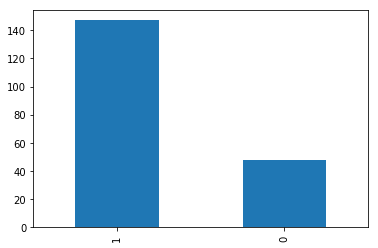

In [3]:
_ = df["status"].value_counts().plot(kind="bar")

Podemos ver que existe um desbalanceamento entre as amostras de pacientes com parkinson e dos que não possuem. Logo, podemos antecipar de antemão que os algoritmos de classificação terão seu desempenho afetado.

# Carregando a matriz de dados
---

Utilizamos o Numpy para realizar a leitura do arquivo de dados. Para aplciar os algoritmos de classificação, não utilizaremos a coluna *name*, uma vez que ela representa apenas o nome do indivíduo (o que é irrelevante para a detecção da doença). Vale comentar que, se utilizarmos esse dado, nosso modelo poderá tornar-se *enviezado*, pois ele pode detectar o padrão apenas no nome do indivíduo, o que não queremos.

Por fins de praticidade, colocaremos a coluna do atributo *status* como o último atributo da matriz de dados.

In [4]:
def load_data():
    data = np.loadtxt("parkinsons.csv",delimiter=',',skiprows=1,usecols=range(1,24))
    status = data[:,16]
    data = np.delete(data,16,1)
    data = np.c_[data,status]
    return data

data = load_data()
data[0]

array([  1.19992000e+02,   1.57302000e+02,   7.49970000e+01,
         7.84000000e-03,   7.00000000e-05,   3.70000000e-03,
         5.54000000e-03,   1.10900000e-02,   4.37400000e-02,
         4.26000000e-01,   2.18200000e-02,   3.13000000e-02,
         2.97100000e-02,   6.54500000e-02,   2.21100000e-02,
         2.10330000e+01,   4.14783000e-01,   8.15285000e-01,
        -4.81303100e+00,   2.66482000e-01,   2.30144200e+00,
         2.84654000e-01,   1.00000000e+00])

Vamos definir uma função para realizar a separação entre os dados de treino e teste a partir de uma certa proporção. Se solicitado, a função poderá também permutar os dados antes de separá-los, a fim de gerar conjuntos diferentes.

In [5]:
def train_test_split(data,train_rate, shuffle=True):
    
    if shuffle:
        np.random.shuffle(data)
    
    train_size = math.floor(train_rate*data.shape[0])

    train_data = data[0: train_size,:]
    test_data = data[train_size:,:]
    
    return train_data,test_data

In [6]:
train,test = train_test_split(data,.8, shuffle=True)
print("Dados de treino: {}".format(train.shape[0]))
print("Dados de teste: {}".format(test.shape[0]))

Dados de treino: 156
Dados de teste: 39


# Algoritmos de Classificação
---

Para permitir uma maior organização entre os algoritmos, definimos uma interface que deverá ser seguida pelos algoritmos que serão a seguit implementados.

Deverá ser comum a todos os seguintes procedomentos:
* **fit**, que é o processamento dos conjuntos de treino;
* **predict**, que retorna a classe predita para uma certa amostra;
* **score**, que informa a acurácia (entre 0 e 1) do modelo.

In [7]:
import abc

class LearningAlgorithm():
    __metaclass__ = abc.ABCMeta
    
    @abc.abstractmethod
    def fit(self,X,Y):
        return
    
    @abc.abstractmethod
    def predict(self,X):
        return
    
    @abc.abstractmethod
    def score(self,X,Y):
        return

Vamos definir também uma função auxiliar de distância euclidiana, para ser utilizada pelos algoritmos de distância.

In [8]:
def euclidian_distance(a,b):
    return np.linalg.norm(a-b)

Para auxiliar no cálculo das métricas, utilizaremos uma estrutura para representar a matriz de confusão dos dados de teste. A matriz conta com as seguintes métricas implementadas:
* Sensibilidade, informando a proporção entre os pacientes que foram corretamente classificados como doentes e os doentes;
* Especificidade, informando a proporção entre os pacientes que foram corretamente classificados como saudáveis e os saudáveis;
* Precisão, informando a proporção entre os pacientes que foram corretamente classificados como doentes e os que foram corretamente classificados;
* Acurácia, informando a proporção entre os pacientes que foram corretamente classificados e todos os pacientes.

In [9]:
class ConfusionMatrix():
    def __init__(self,label,predicted):
        self.matrix = np.array([[0,0],[0,0]])
        
        for l,p in zip(label,predicted):
            try:
                l = int(l)
                p = int(p)
                self.matrix[l][p] += 1
            except:
                raise Exception("Invalid value. Values must be 0 or 1")
                
    def true_positive(self):
        return self.matrix[1][1]
    
    def true_negative(self):
        return self.matrix[0][0]
    
    def false_positive(self):
        return self.matrix[0][1]
    
    def false_negative(self):
        return self.matrix[1][0]
    
    def sensitivity(self):
        if self.true_positive() == 0:
            return 0
        
        return self.true_positive()/(self.true_positive()+self.false_negative())
            
    def specificity(self):
        if self.true_negative() == 0:
            return 0
        
        return self.true_negative()/(self.true_negative()+self.false_positive())
    
    def precision(self):
        if self.true_positive() == 0:
            return 0
        
        return self.true_positive()/(self.true_positive()+self.false_positive())
        
    
    def accuracy(self):
        return (self.true_positive()+self.true_negative())/(np.sum(self.matrix))
        

## Distância Mínima ao Centróide (DMC)

O primeiro algoritmo apresentado será o da *Distância Mínima ao Centróide*. Ele calcula os centróides das classes inseridas nos dados de treino e, na sua predição, ele retorna a classe do centróide mais próximo.

In [10]:
class NearestCentroideClassifier(LearningAlgorithm):
    
    def __init__(self, distanceAlgorithm=euclidian_distance):
        self.distance = distanceAlgorithm
    
    def fit(self,X,Y):   
        classes = {}
        for (x,y) in zip(X,Y):
            if not y in classes:
                classes[y] = []
            
            classes[y].append(x)
        
        self.clusters = {}
        for k in classes:
            data = np.array(classes[k])
            cluster = np.mean(data,axis=0)
            self.clusters[k] = cluster
            
    def predict(self,x):
        distances = [(c,self.distance(x,self.clusters[c])) for c in self.clusters]
        distances = sorted(distances,key=lambda x: x[1])
        return distances[0][0]
    
    
    def score(self,X,Y):
        predictions = [1 if self.predict(x)==y else 0 for x,y in zip(X,Y)] 
        return sum(predictions)/len(predictions)

Aplicando o algoritmo, obtemos os seguintes resultados para as métricas:

In [11]:
model = NearestCentroideClassifier()
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

Sensibilidade: 69.7%
Especificidade: 33.3%
Precisão: 85.2%
Accuracy: 64.1%


## K Vizinhos mais Próximos (KNN)

O segundo algoritmo apresentado é semelhante ao DMC: ao invés de calcular os centróides das classes, ele armazena os dados de treino. Para prever a classe, ele identifica as *k* amostras mais próximas do elemento a ser classificado e verifica a classe que mais se repete.

In [12]:
from collections import Counter


class KNNClassifier(LearningAlgorithm):
    
    def __init__(self,k=10, distanceAlgorithm=euclidian_distance):
        self.k = k
        self.distance = distanceAlgorithm
    
    def fit(self,X,Y,itter=100):
        self.data = [(x,y) for x,y in zip(X,Y)]
        
    def predict(self,x):
        distances = [(d[1],self.distance(x,list(d[0]))) for d in self.data]
        distances = sorted(distances,key=lambda x: x[1])
        top_k = [c for c,_ in distances[:self.k]]
        counter = Counter(top_k)
        return counter.most_common(1)[0][0]
    
    
    def score(self,X,Y):
        predictions = [1 if self.predict(x)==y else 0 for x,y in zip(X,Y)] 
        return sum(predictions)/len(predictions)

Este algoritmo possui um hiperparâmetro: um parâmetro que não é *aprendido*, que é o número de elementos mais próximos *k*. Como possuímos apenas 2 classes, utilizamos o valor *k=11* para que não haja a possibilidade de haver empate entre o número de classes mais próximas.

In [13]:
model = KNNClassifier(k=11)
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

Sensibilidade: 97.0%
Especificidade: 16.7%
Precisão: 86.5%
Accuracy: 84.6%


## Vizinho Mais Próximo (NN)

O *Vizinho Mais Próximo* é um caso particular do *KNN*, onde ***k = 1***.

In [14]:
class NNClassifier(KNNClassifier):
    def __init__(self, distanceAlgorithm=euclidian_distance):
        KNNClassifier.__init__(self, k=1, distanceAlgorithm=distanceAlgorithm)

Aplicando o algoritmo, obtemos os seguintes resultados para as métricas:

In [15]:
model = NNClassifier()
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

Sensibilidade: 87.9%
Especificidade: 66.7%
Precisão: 93.5%
Accuracy: 84.6%


## Classificador Quadrático (CQ)

O classificador quadrático pode ser visto também como um caso particular do DMC, onde a função de distância utilizada é a *Distância de Mahalanobis* entre a amostra a ser classificada e o centróide da classe. Logo, definimos uma função de *alta ordem* que gera uma função que computa essa distância a partir de uma certa matriz *Q*.

In [16]:
def generate_mahalanobis_distance(Q):
    def distance_function(x,y):
        z = x - y
        right = np.matmul(Q,z)
        left = np.matmul(z.transpose(),right)
        return math.sqrt(left)
    
    return distance_function

A matriz *Q* é muito importante para essa métrica, pois ela incrementa a semântica do resultado. Por exemplo: caso a matriz seja a própria identidade, a distância é meramente euclidiana. Neste classificador, o inverso da *Matriz de Convariância* é utilizado. Portanto, precisamos calculá-la para cada classe.

In [17]:
def covariance(X):
    m = np.mean(X,axis=1).transpose()
    n = X.shape[1]
    R = np.matmul(X,X.transpose())/n
    return R - np.outer(m,m.transpose())

Como a utilizaremos o **inverso** da matriz de convariância, precisamos checar se a matriz é *invertível* ou não. Para isso, basta checarmos seu posto(*rank*) e seu condicionamento.

**OBS**: utilizei o valor 30 como limite superior para o condicionamento por ser o mesmo número utilizado pelo MatLab.

In [18]:
def is_invertible(X):
    rank = np.linalg.matrix_rank(X)
    cond = np.linalg.cond(X)
    if rank < X.shape[0]:
        return False, "Matrix isn't inversible because has rank {}".format(rank)
    if cond > 30:
        return False, "Matrix is ill-conditioned({})".format(cond)
    return True, ""

Caso a matriz não seja invertível, precisamos encontrar uma outra matriz que possa ser utilizada, mas partindo da matriz de covariância original. Utilizaremos duas abordagens:
* Regularização de Friedman
* Matriz de Covariância agregada

### Regularização de Friedman (F)

O método da Regularização de Friedman pode ser encontrado em seu trabalho *[Regularized Discriminant Analysis](https://www.jstor.org/stable/pdf/2289860.pdf)*. Utilizamos uma função que recebe os parâmetros *l*(*lambda*), *g*(*gamma*) e os dados agrupados por suas classes e retornamos as matrizes de covariâncias regularizadas de cada classe.

In [19]:
def friedman_regularization(l,g,clusters):
    sk = {}
    
    wk = {}
    
    cov_lambda = {}
    
    for k in clusters:
        data = np.array(clusters[k])
        wk[k] = data.shape[0]
        sk[k] = covariance(data.transpose())*wk[k]
    
    s = sum([sk[k] for k in sk])
    w = sum([wk[k] for k in wk])
    
    for k in clusters:
        wk_lambda = (1-l)*wk[k] + l*w
        sk_lambda = (1-l)*sk[k] + l*s
        cov_lambda[k] = (1/wk_lambda)*sk_lambda
        
    return {
        k: (1-g)*cov_lambda[k] + (g/cov_lambda[k].shape[0])*np.trace(cov_lambda[k])*np.eye(cov_lambda[k].shape[0],cov_lambda[k].shape[0]) \
        for k in clusters
    }

### Covariância Agregada (P)

A matriz de covariância agregada é o somatório das matrizes de covariâncias das classes multiplicadas pela probabilidade a priori(porcentagem dos dados) de cada classe. A função recebe os dados agrupados por suas classes e retorna a matriz de covariância agregada.

In [20]:
def pooled_covariance(clusters):
    sigma = None
    n = sum([len(clusters[k]) for k in clusters])
    
    for k in clusters:
        data = np.array(clusters[k])
        cov = covariance(data.transpose())
        if sigma is None:
            sigma = (cov.shape[0]/n)*cov
        else:
            sigma += (cov.shape[0]/n)*cov
        
    return sigma
        

Por fim, podemos implementar o algoritmo do *Classificador Quadrático*(CQ). Ele possui um hiperparâmetro que é a estratégia para utilizar caso a matriz de covariância não seja invertível. As opções são *friedman*, a qual utiliza o método de regularização de Friedman, e *pooled*, que computa a matriz de covariância agregada.

In [21]:
class DistanceCell():
        def __init__(self,m,Q):
            self.m = m
            self.distance = generate_mahalanobis_distance(Q)
            
        def calculate(self, x):
            return self.distance(self.m,x)

class QuadraticClassifier(LearningAlgorithm):
    
    def __init__(self,check_invertibility=False,pinv_mode="friedman"):
        self.check_invertibility = check_invertibility
        self.pinv_mode = pinv_mode
    
    def fit(self,X,Y,itter=100):
        classes = {}
        for (x,y) in zip(X,Y):
            if not y in classes:
                classes[y] = []
            
            classes[y].append(x)
        
        self.cells = {}
        
        if self.check_invertibility:
            need_pinv = False
            for k in classes:
                data = np.array(classes[k])
                m = np.mean(data,axis=0)
                cov = covariance(data.transpose())

                invertibility, message = is_invertible(cov)
                if invertibility:
                    self.cells[k] = DistanceCell(m,np.linalg.inv(cov))
                else:
                    need_pinv = True
                    logger.warning(message)
                    break
            
            if need_pinv:
                if self.pinv_mode == "friedman":
                    logger.info("Computing regularized covariances matrices")
                    covs = friedman_regularization(.5,1,classes)
                    for k in classes:
                        m = np.mean(data,axis=0)
                        self.cells[k] = DistanceCell(m,np.linalg.inv(covs[k]))
                        
                elif self.pinv_mode == "pooled":
                    logger.info("Computing pooled covariance matrix")
                    cov = pooled_covariance(classes)
                    inv_cov = np.linalg.inv(cov)
                    for k in classes:
                        m = np.mean(data,axis=0)
                        self.cells[k] = DistanceCell(m,inv_cov)
                else:
                    raise Exception("Invalid pinv method: {}".format(self.pinv_mode))
            
        else:
            for k in classes:
                data = np.array(classes[k])
                m = np.mean(data,axis=0)
                cov = covariance(data.transpose())
                self.cells[k] = DistanceCell(m,np.linalg.inv(cov))
                    
            
    def predict(self, x):
        distances = [(c,self.cells[c].calculate(x)) for c in self.cells]
        distances = sorted(distances,key=lambda x: x[1])
        return distances[0][0]
    
    
    def score(self,X,Y):
        predictions = [1 if self.predict(x)==y else 0 for x,y in zip(X,Y)] 
        return sum(predictions)/len(predictions)

Executando o algoritmo com a estratégia *friedman*, obtemos os seguintes resultados:

In [22]:
model = QuadraticClassifier(check_invertibility=True,pinv_mode="pooled")
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

2018-10-24 08:27:06,613 - root - WARNING - Matrix isn't inversible because has rank 19
2018-10-24 08:27:06,614 - root - INFO - Computing pooled covariance matrix


Sensibilidade: 100.0%
Especificidade: 0.0%
Precisão: 84.6%
Accuracy: 84.6%


Executando o algoritmo com a estratégia *pooled*, obtemos os seguintes resultados:

In [23]:
model = QuadraticClassifier(check_invertibility=True,pinv_mode="friedman")
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

2018-10-24 08:27:06,635 - root - WARNING - Matrix isn't inversible because has rank 19
2018-10-24 08:27:06,637 - root - INFO - Computing regularized covariances matrices


Sensibilidade: 0.0%
Especificidade: 100.0%
Precisão: 0.0%
Accuracy: 15.4%


## Classificador Quadrático Gaussiano

Este algoritmo utiliza da função de *densidade probabilística* para prever a classe de uma amostra. Para uma certa amostra *X* de teste, o algoritmo calcula a *probabilidade a posteriori* para cada classe *C*. A classe da amostra será aquela de maior probabilidade.

Como esse método também possui a necessidade de calcular a inversa da matriz de covariância, precisamos do hiperparâmetro para a estratégia caso a matriz de covariância não seja invertível.

In [24]:
class QuadraticGaussianClassifier(LearningAlgorithm):

    def __init__(self,check_invertibility=False,pinv_mode="friedman"):
        self.check_invertibility = check_invertibility
        self.pinv_mode = pinv_mode

    def fit(self,X,Y,itter=100):   
        classes = {}
        n = X.shape[0]
        for (x,y) in zip(X,Y):
            if not y in classes:
                classes[y] = []
            
            classes[y].append(x)
        
        self.cells = {}
        
        if self.check_invertibility:
            need_pinv = False
            for k in classes:
                data = np.array(classes[k])
                m = np.mean(data,axis=0)
                std = np.std(data,axis=0)
                cov = covariance(data.transpose())
                
                invertibility, message = is_invertible(cov)
                if invertibility:
                    self.cells[k] = {
                        "icov": np.linalg.inv(cov),
                        "cov_det": np.linalg.det(cov),
                        "mean": m,
                        "std": std,
                        "prob_priori": data.shape[0]/n
                    }
                    
                else:
                    need_pinv = True
                    logger.warning(message)
                    break
                
            if need_pinv:
                if self.pinv_mode == "friedman":
                    logger.info("Computing regularized covariances matrices")
                    covs = friedman_regularization(.5,1,classes)
                    for k in classes:
                        m = np.mean(data,axis=0)
                        std = np.std(data,axis=0)
                        cov = covs[k]
                        self.cells[k] = {
                            "icov": np.linalg.inv(cov),
                            "cov_det": np.linalg.det(cov),
                            "mean": m,
                            "std": std,
                            "prob_priori": data.shape[0]/n
                        }

                elif self.pinv_mode == "pooled":
                    logger.info("Computing pooled covariance matrix")
                    cov = pooled_covariance(classes)
                    inv_cov = np.linalg.inv(cov)
                    for k in classes:
                        m = np.mean(data,axis=0)
                        std = np.std(data,axis=0)
                        self.cells[k] = {
                            "icov":inv_cov,
                            "cov_det": np.linalg.det(cov),
                            "mean": m,
                            "std": std,
                            "prob_priori": data.shape[0]/n
                        }
                else:
                    raise Exception("Invalid pinv method: {}".format(self.pinv_mode))
            
        else:
            for k in classes:
                data = np.array(classes[k])
                m = np.mean(data,axis=0)
                std = np.std(data,axis=0)
                cov = covariance(data.transpose())
                self.cells[k] = {
                    "icov": np.linalg.inv(cov),
                    "cov_det": np.linalg.det(cov),
                    "mean": m,
                    "std": std,
                    "prob_priori": data.shape[0]/n
                }
            
    def __prob__(self,x,k):
        s = self.cells[k]["std"]
        m = self.cells[k]["mean"]
        ic = self.cells[k]["icov"]
        cov_det = self.cells[k]["cov_det"]
        prob_priori = self.cells[k]["prob_priori"]
        z = x-m
        return math.log(prob_priori) \
            - 0.5*np.matmul(z, np.matmul(ic,z)) - 0.5*math.log(cov_det)
            
    def predict(self,x):
        distances = [(k,self.__prob__(x,k)) for k in self.cells]
        distances = sorted(distances,key=lambda x: x[1], reverse=True)
        return distances[0][0]
    
    
    def score(self,X,Y):
        predictions = [1 if self.predict(x)==y else 0 for x,y in zip(X,Y)] 
        return sum(predictions)/len(predictions)

Executando o algoritmo com a estratégia *friedman*, obtemos os seguintes resultados:

In [25]:
model = QuadraticGaussianClassifier(check_invertibility=True, pinv_mode="friedman")
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

2018-10-24 08:27:06,812 - root - WARNING - Matrix isn't inversible because has rank 19
2018-10-24 08:27:06,814 - root - INFO - Computing regularized covariances matrices


Sensibilidade: 97.0%
Especificidade: 0.0%
Precisão: 84.2%
Accuracy: 82.1%


Executando o algoritmo com a estratégia *pooled*, obtemos os seguintes resultados:

In [26]:
model = QuadraticGaussianClassifier(check_invertibility=True, pinv_mode="pooled")
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

2018-10-24 08:27:06,839 - root - WARNING - Matrix isn't inversible because has rank 19
2018-10-24 08:27:06,841 - root - INFO - Computing pooled covariance matrix


Sensibilidade: 100.0%
Especificidade: 0.0%
Precisão: 84.6%
Accuracy: 84.6%


## Naive Bayes (NB)

Este classificador é um caso particular do CQG, porém ele assume que os dados são **descorrelacionados**, logo, a matriz de covariância é uma matriz *diagonal*. Portanto, não precisamos realizar checagens quanto a invertibilidade.

In [27]:
class NormalNaiveBayes(LearningAlgorithm):
   
    def fit(self,X,Y):   
        classes = {}
        n = X.shape[0]
        for (x,y) in zip(X,Y):
            if not y in classes:
                classes[y] = []
            
            classes[y].append(x)
        
        self.cells = {}
        for k in classes:
            data = np.array(classes[k])
            m = np.mean(data,axis=0)
            std = np.std(data,axis=0)
            var = np.var(data,axis=0)
            self.cells[k] = {
                "icov": np.linalg.inv(np.diag(var)),
                "cov_det": np.prod(var),
                "mean": m,
                "std": std,
                "prob_priori": data.shape[0]/n
            }
            
    def __prob__(self,x,k):
        s = self.cells[k]["std"]
        m = self.cells[k]["mean"]
        ic = self.cells[k]["icov"]
        cov_det = self.cells[k]["cov_det"]
        prob_priori = self.cells[k]["prob_priori"]
        z = x-m
        return math.log(prob_priori) \
            - 0.5*np.matmul(z, np.matmul(ic,z)) - 0.5*math.log(cov_det)
            
    def predict(self,x):
        distances = [(k,self.__prob__(x,k)) for k in self.cells]
        distances = sorted(distances,key=lambda x: x[1], reverse=True)
        return distances[0][0]
    
    
    def score(self,X,Y):
        predictions = [1 if self.predict(x)==y else 0 for x,y in zip(X,Y)] 
        return sum(predictions)/len(predictions)

Aplicando o algoritmo, obtemos os seguintes resultados para as métricas:

In [28]:
model = NormalNaiveBayes()
model.fit(train[:,:-1],train[:,-1])
predicted = [model.predict(x) for x in test[:,:-1]]
conf_matrix = ConfusionMatrix(test[:,-1],predicted)
print("Sensibilidade: {:.1f}%".format(100*conf_matrix.sensitivity()))
print("Especificidade: {:.1f}%".format(100*conf_matrix.specificity()))
print("Precisão: {:.1f}%".format(100*conf_matrix.precision()))
print("Accuracy: {:.1f}%".format(100*conf_matrix.accuracy()))

Sensibilidade: 66.7%
Especificidade: 83.3%
Precisão: 95.7%
Accuracy: 69.2%


Agora que conhecemos os classificadores, utilizaremos uma função para executar 100 vezes os experimentos para cada algoritmo, sempre permutando os dados e dividindo em treino e teste. Utilziaremos o Pandas para apresentar a tabela com os resultados.

In [29]:
def run_experiments(data, experiments_indices):
    logger.setLevel(logging.CRITICAL)
    models = {
        "NB": NormalNaiveBayes(),
        "CQ(P)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQG(P)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="pooled"),
        "CQ(F)": 
            QuadraticClassifier(check_invertibility=True,pinv_mode="friedman"),
        "CQG(F)": 
            QuadraticGaussianClassifier(check_invertibility=True,pinv_mode="friedman"),
        "DMC": NearestCentroideClassifier(),
        "KNN(k=11)": KNNClassifier(k=11),
        "NN": NNClassifier()
    }

    acc_results = []
    metrics_results = []
    for model_name in models:
        model = models[model_name]
        min_score = 101
        max_score = -1

        scores = []
        sensitivities = []
        specificities = []
        precisions = []
        for indices in experiments_indices:
            
            train,test = train_test_split(data[indices,:],.8, shuffle=False)
            model.fit(train[:,:-1],train[:,-1])

            predicted = [model.predict(x) for x in test[:,:-1]]
            conf_matrix = ConfusionMatrix(test[:,-1],predicted)

            sensitivities.append(conf_matrix.sensitivity())
            specificities.append(conf_matrix.specificity())
            precisions.append(conf_matrix.precision())

            score = conf_matrix.accuracy()
            scores.append(score)

            if score > max_score:
                max_score = score

            if score < min_score:
                min_score = score

        mean = np.mean(scores)
        std = np.std(scores)
        median = np.median(scores)

        acc_results.append({
            "1 - Alg": model_name,
            "2 - Média(%)": mean*100,
            "3 - Mediana(%)": median*100,
            "4 - Min/Max(%)": "{:.1f} / {:.1f}".format(min_score*100,max_score*100),
            "5 - Desv. Pad.(%)": std*100
        })
        
        metrics_results.append({
            "1 - Alg": model_name,
            "6 - Sensibilidade(%)": np.mean(sensitivities)*100,
            "7 - Especificidade(%)": np.mean(specificities)*100,
            "8 - Precisão(%)": np.mean(precisions)*100
        })

    return pd.DataFrame(acc_results).round(1), pd.DataFrame(metrics_results).round(1)

Para garantir uma melhor comparação entre os experimentos com as próximas etapas do relatório, geramos 100 permutações dos índices para serem utilizadas nos experimentos, a fim de garantir que em, todos eles, os mesmos conjuntos de treino e sejam utilizados.

In [30]:
experiments_indices = [np.random.permutation(range(data.shape[0])) for _ in range(100)]
experiments_indices[0]

array([175,  91,  38, 154, 142,  63, 110,  29, 177,  81,  83, 112, 146,
       176,  54, 163,  86,  12,   1, 128,  48, 123,  97,  61,  10,   0,
        41,  76,  87,  98,  25,  94, 113,  18, 105, 187, 108, 111, 127,
        11,  90, 152, 182, 157,  96, 129,   6, 185,  35, 194, 102, 117,
        16,  28,  32, 115, 100, 147, 186,  69, 125,  85, 114,   7,  65,
       132, 188,  99, 143, 153, 138, 139,  79,  77, 149, 141, 160,  53,
       130,  45,  50, 118, 107,  21, 172,  19,  57,  84,  31,  24, 159,
       158, 193,  89,  95,  75, 144,  34,   4, 173,  26, 137,  80,  74,
        60, 181,  46,  51,  14,  73,  15, 170,  42, 106, 120, 165,  17,
       156, 174,  40,  62, 169, 180, 150,  68, 109, 135,   9, 164, 121,
        70, 155,  59, 178,  20, 162,  23, 168,  58,  44, 134, 148,  55,
       171,  27, 191,  49,  92,  72,  67,  78,  71, 161,  88, 189, 124,
        82,  30,   8, 126, 103, 133, 190,  33, 104,  52,  22, 119,   2,
       136, 131, 122,  43, 167, 140,   5, 183, 179,  47,  93, 18

Executando os experimentos, obtemos as seguintes informações sobre as acurácias dos algoritmos:

In [31]:
acc_df, metrics_df = run_experiments(data,experiments_indices)
acc_df

,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,68.9,69.2,51.3 / 82.1,6.2
1,CQ(P),61.4,71.8,12.8 / 87.2,22.4
2,CQG(P),61.4,71.8,12.8 / 87.2,22.4
3,CQ(F),27.4,25.6,12.8 / 79.5,11.1
4,CQG(F),70.0,76.9,17.9 / 92.3,15.0
5,DMC,71.1,71.8,56.4 / 84.6,6.4
6,KNN(k=11),80.2,79.5,61.5 / 92.3,5.2
7,NN,83.5,84.6,69.2 / 94.9,5.2


Obtemos, também, as seguintes métricas:

In [32]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,62.7,87.9,93.7
1,CQ(P),73.0,27.0,54.4
2,CQG(P),73.0,27.0,54.4
3,CQ(F),4.0,96.0,2.9
4,CQG(F),79.4,42.5,78.7
5,DMC,73.8,63.9,85.5
6,KNN(k=11),95.6,36.6,81.3
7,NN,88.9,68.9,89.1


Analisando as tabelas dos experimentos, podemos dizer que:
* O NN foi o que teve o melhor acurácia média;
* O KNN e NN tiveram resultados mais constantes, possuindo menor desvio padrão;
* O KNN foi o mais sensível;
* O CQ(F) foi o mais específico;
* O NB foi o mais preciso.

# Normalização de dados
---

Uma técnica que pode servir de auxílio para melhorar os resultados dos algoritmos é normalizar os dados. Para este exemplo, normalizaremos os atributos utilizando norma euclidiana.

In [33]:
data = load_data()
features = data[:,:-1]
data[:,:-1] = features/np.linalg.norm(features,axis=0)
data[0]

array([ 0.05381992,  0.05186168,  0.04325569,  0.07125738,  0.0894753 ,
        0.05970461,  0.08995581,  0.05964837,  0.08908063,  0.08901622,
        0.08377133,  0.1041168 ,  0.07231317,  0.08375863,  0.03343418,
        0.06746194,  0.05833295,  0.08106413, -0.05955421,  0.07908342,
        0.06832239,  0.09049198,  1.        ])

In [34]:
acc_df, metrics_df = run_experiments(data,experiments_indices)
acc_df

,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,70.1,69.2,48.7 / 89.7,7.9
1,CQ(P),59.1,71.8,10.3 / 89.7,24.6
2,CQG(P),59.1,71.8,10.3 / 89.7,24.6
3,CQ(F),75.6,74.4,61.5 / 89.7,5.8
4,CQG(F),37.8,34.6,10.3 / 69.2,13.4
5,DMC,69.2,69.2,48.7 / 87.2,8.5
6,KNN(k=11),85.6,84.6,74.4 / 97.4,4.7
7,NN,90.7,89.7,76.9 / 100.0,4.2


In [35]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,64.1,88.7,94.8
1,CQ(P),68.0,32.0,51.3
2,CQG(P),68.0,32.0,51.3
3,CQ(F),100.0,0.0,75.6
4,CQG(F),27.2,70.6,72.0
5,DMC,63.8,86.3,93.4
6,KNN(k=11),95.6,55.4,86.9
7,NN,93.0,84.4,94.8


Analisando as tabelas dos experimentos, podemos dizer que:
* O NN foi o que teve o melhor acurácia média;
* O KNN e NN tiveram resultados mais constantes, possuindo menor desvio padrão;
* O CQ(F) foi o mais sensível;
* O NB foi o mais específico;
* O NB e o NN foram os mais precisos.

Em termos de acurácia, os mesmos algoritmos se sobressaíram em relação aos dados originais, porém obtivemos uma melhoria na acurácia média.

# Análise de Componentes Principais (PCA)
---

A análise de componentes principais visa reduzir a dimensão dos dados. Podemos aplicá-la para reduzir o esforço computacional dos algoritmos sacrificando(ou não), uma pequena fração da acurácia.

Primeiramente, vamos recarregar os dados.

In [36]:
data = load_data()
data[0]

array([  1.19992000e+02,   1.57302000e+02,   7.49970000e+01,
         7.84000000e-03,   7.00000000e-05,   3.70000000e-03,
         5.54000000e-03,   1.10900000e-02,   4.37400000e-02,
         4.26000000e-01,   2.18200000e-02,   3.13000000e-02,
         2.97100000e-02,   6.54500000e-02,   2.21100000e-02,
         2.10330000e+01,   4.14783000e-01,   8.15285000e-01,
        -4.81303100e+00,   2.66482000e-01,   2.30144200e+00,
         2.84654000e-01,   1.00000000e+00])

Em seguida, precisamos centralizar os dados. Para isso, devemos subtrair os vetores das amostras pelo vetor da média dos dados.

In [37]:
mean = np.mean(data[:,:-1], axis=0)
data[:,:-1] = data[:,:-1] - mean
np.mean(data[:,:-1], axis=0)

array([ -2.49236529e-14,  -4.66407539e-14,   5.02845628e-15,
        -3.29597460e-18,  -1.74619100e-20,  -1.34997071e-18,
        -2.35744472e-19,   6.18273239e-18,   3.09581420e-18,
        -3.10293102e-17,   1.02304205e-18,  -7.09902222e-18,
        -5.87137176e-19,   1.58882878e-17,   4.62592927e-19,
        -7.41515111e-15,   9.84967094e-17,  -2.94351438e-16,
        -4.73695157e-16,   1.61978693e-16,  -2.11796392e-16,
        -2.41971685e-17])

Com os dados centralizados, calculamos sua matriz de covariância.

In [38]:
cov = np.matmul(data[:,:-1].transpose(),data[:,:-1])

Devemos então encontrar os autovetores e os autovalores da matriz de covariância.

In [39]:
values, vectors = np.linalg.eig(cov)
values

array([  1.69694607e+06,   5.08028884e+05,   1.18998975e+05,
         3.70992640e+03,   9.30927495e+01,   1.42299877e+01,
         2.38000515e+00,   1.09468329e+00,   6.15634482e-01,
         2.68866853e-01,   1.04244929e-01,   8.21629685e-02,
         1.37375806e-02,   3.08815071e-03,   1.49834231e-03,
         5.94082820e-04,   9.76909931e-05,   3.98365688e-05,
         1.13400559e-05,   5.06836169e-09,   1.04230725e-09,
         1.26793148e-09])

Os autovalores correspondem as variâncias dos atributos dos dados. Portanto, se escolhermos os *k* primeiros autovalores, manteremos uma fração dessa variância e reduziremos a dimensão dos dados.

In [40]:
values = values/sum(values)
for i in range(1,23):
    print("Porcentagem da variância preservada até o {}º autovalor: {:.2f}% ".format(i,100*sum(values[0:i])))

Porcentagem da variância preservada até o 1º autovalor: 72.90% 
Porcentagem da variância preservada até o 2º autovalor: 94.72% 
Porcentagem da variância preservada até o 3º autovalor: 99.84% 
Porcentagem da variância preservada até o 4º autovalor: 100.00% 
Porcentagem da variância preservada até o 5º autovalor: 100.00% 
Porcentagem da variância preservada até o 6º autovalor: 100.00% 
Porcentagem da variância preservada até o 7º autovalor: 100.00% 
Porcentagem da variância preservada até o 8º autovalor: 100.00% 
Porcentagem da variância preservada até o 9º autovalor: 100.00% 
Porcentagem da variância preservada até o 10º autovalor: 100.00% 
Porcentagem da variância preservada até o 11º autovalor: 100.00% 
Porcentagem da variância preservada até o 12º autovalor: 100.00% 
Porcentagem da variância preservada até o 13º autovalor: 100.00% 
Porcentagem da variância preservada até o 14º autovalor: 100.00% 
Porcentagem da variância preservada até o 15º autovalor: 100.00% 
Porcentagem da variânc

Podemos ver que os 4 primeiros autovalores representam, aproximadamente, 100% da variância. Portanto, utilizaremos os 4 primeiros autovetores para transformar os dados.

In [41]:
pca_vectors = vectors[:,:4]
pca_vectors.shape

data = np.c_[np.matmul(data[:,:-1],pca_vectors), data[:,-1]]
data.shape

(195, 5)

Com os dados transformados, podemos executar novamente os experimentos, obtendo as seguintes informações sobre as acurácias:

In [42]:
acc_df, metrics_df = run_experiments(data,experiments_indices)
acc_df

,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,78.4,79.5,66.7 / 89.7,5.6
1,CQ(P),59.1,71.8,10.3 / 89.7,24.6
2,CQG(P),59.1,71.8,10.3 / 89.7,24.6
3,CQ(F),25.4,25.6,10.3 / 74.4,8.9
4,CQG(F),68.1,74.4,15.4 / 87.2,15.1
5,DMC,70.7,71.8,48.7 / 84.6,6.8
6,KNN(k=11),80.4,79.5,66.7 / 94.9,5.4
7,NN,83.2,83.3,71.8 / 94.9,5.0


Obtemos, também, as seguintes métricas:

In [43]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,88.9,46.5,83.7
1,CQ(P),68.0,32.0,51.3
2,CQG(P),68.0,32.0,51.3
3,CQ(F),2.0,98.0,1.5
4,CQG(F),77.8,37.4,78.4
5,DMC,74.1,60.4,85.3
6,KNN(k=11),95.8,33.0,81.6
7,NN,88.7,66.7,89.2


Analisando as tabelas dos experimentos, podemos dizer que:
* O NN foi o que teve o melhor desempenho médio, seguido do KNN;
* O NN foi o que teve resultados mais constantes, possuindo menor desvio padrão;
* O KNN foi o mais sensível;
* O CQ(F) foi o mais específico;
* O NN foi o mais preciso;

Utilizando o PCA, obtivemos análises bem similares aos dados originais, porém utilizando apenas 4 colunas de dados, permitindo que algoritmos como o KNN e o NN sejam executados de maneira mais rápida.

# Discriminante Linear de Fisher (LDA)
---

Utilizaremos o *Discriminante Linear de Fisher*(LDA) para, também, reduzir a dimensionalidade dos dados.

Inicialmente, precisamos recarregar os dados.

In [44]:
data = load_data()
data[0]

array([  1.19992000e+02,   1.57302000e+02,   7.49970000e+01,
         7.84000000e-03,   7.00000000e-05,   3.70000000e-03,
         5.54000000e-03,   1.10900000e-02,   4.37400000e-02,
         4.26000000e-01,   2.18200000e-02,   3.13000000e-02,
         2.97100000e-02,   6.54500000e-02,   2.21100000e-02,
         2.10330000e+01,   4.14783000e-01,   8.15285000e-01,
        -4.81303100e+00,   2.66482000e-01,   2.30144200e+00,
         2.84654000e-01,   1.00000000e+00])

Em seguida, precisamos separar os dados de acordo com suas classes e calcular seus centróides.

In [45]:
classes = {}
for (x,y) in zip(data[:,:-1],data[:,-1]):
    if not y in classes:
        classes[y] = []

    classes[y].append(x)

classes = {k: np.array(classes[k]) for k in classes}

means = [np.mean(classes[k], axis = 0) for k in classes]
means

[array([  1.45180762e+02,   1.88441463e+02,   1.06893558e+02,
          6.98925170e-03,   5.06802721e-05,   3.75748299e-03,
          3.90034014e-03,   1.12730612e-02,   3.36581633e-02,
          3.21204082e-01,   1.76757823e-02,   2.02846939e-02,
          2.76004082e-02,   5.30272789e-02,   2.92109524e-02,
          2.09740476e+01,   5.16815918e-01,   7.25407939e-01,
         -5.33341972e+00,   2.48132667e-01,   2.45605804e+00,
          2.33828224e-01]),
 array([  1.81937771e+02,   2.23636750e+02,   1.45207292e+02,
          3.86604167e-03,   2.33750000e-05,   1.92500000e-03,
          2.05604167e-03,   5.77604167e-03,   1.76152083e-02,
          1.62958333e-01,   9.50354167e-03,   1.05085417e-02,
          1.33047917e-02,   2.85114583e-02,   1.14827083e-02,
          2.46787500e+01,   4.42551875e-01,   6.95715562e-01,
         -6.75926387e+00,   1.60292000e-01,   2.15449073e+00,
          1.23017104e-01])]

Precisamos também calcular as matrizes de *Dispersão Intraclasse*(Sw) e *Dispersão Interclasse*(Sb).

In [46]:
n = data.shape[1]-1

sw = []
m = np.mean(data[:,:-1],axis=0)
sb = []

for mi,k in zip(means,classes):
    ni = len(classes[k])
    sb.append(ni*np.outer(mi-m,mi-m))
    
    s = np.zeros((n,n))
    for x in classes[k]:
        z = x-mi
        s += np.outer(z,z)
    sw.append(s)
    
sw = sum(sw)
sb = sum(sb)

sw.shape,sb.shape

((22, 22), (22, 22))

Agora, encontramos os autovetores e autovalroes da matriz resultante pela multiplicação da inversa da matriz *Sw* pela matriz *Sb*.

In [47]:
Z = np.matmul(np.linalg.inv(sw),sb)
values, vectors = np.linalg.eig(Z)

values[0], vectors[0]

((0.97138931805789208+0j), array([  6.71375288e-07 +0.00000000e+00j,
         -6.65562697e-07 +0.00000000e+00j,
         -6.98914917e-07 +0.00000000e+00j,
         -6.53311112e-07 -6.84039910e-08j,
         -6.53311112e-07 +6.84039910e-08j,
         -1.79622799e-07 +0.00000000e+00j,
         -1.80449158e-07 +1.49695740e-06j,
         -1.80449158e-07 -1.49695740e-06j,
          1.30404798e-07 +0.00000000e+00j,
         -4.49905070e-08 -2.19005306e-08j,
         -4.49905070e-08 +2.19005306e-08j,
         -4.97202603e-08 -5.39079712e-08j,
         -4.97202603e-08 +5.39079712e-08j,
          3.01617277e-06 +0.00000000e+00j,
          6.10508192e-08 -1.99724149e-07j,
          6.10508192e-08 +1.99724149e-07j,
         -1.12781924e-07 +2.22867214e-07j,
         -1.12781924e-07 -2.22867214e-07j,
         -5.79770723e-08 +0.00000000e+00j,
          9.59254751e-07 -2.91840868e-07j,
          9.59254751e-07 +2.91840868e-07j,   3.60977589e-05 +0.00000000e+00j]))

Os autovetores e autovalores deram números *Complexos*. Porém, esses números são muito próximos de 0. Portanto, iremos desconsiderar sua parte imaginária, mantendo **apenas** a parte Real.

In [48]:
values = np.real(values)
vectors = np.real(vectors)
values[0], vectors[0]

(0.97138931805789208,
 array([  6.71375288e-07,  -6.65562697e-07,  -6.98914917e-07,
         -6.53311112e-07,  -6.53311112e-07,  -1.79622799e-07,
         -1.80449158e-07,  -1.80449158e-07,   1.30404798e-07,
         -4.49905070e-08,  -4.49905070e-08,  -4.97202603e-08,
         -4.97202603e-08,   3.01617277e-06,   6.10508192e-08,
          6.10508192e-08,  -1.12781924e-07,  -1.12781924e-07,
         -5.79770723e-08,   9.59254751e-07,   9.59254751e-07,
          3.60977589e-05]))

Agora, analisamos as porcentagens de variância preservada até cada autovalor.

In [49]:
values = values/sum(values)
for i in range(1,23):
    print("Porcentagem da variância preservada até o {}º autovalor: {}% ".format(i,100*sum(values[0:i])))

Porcentagem da variância preservada até o 1º autovalor: 99.99999978537427% 
Porcentagem da variância preservada até o 2º autovalor: 99.99999999025356% 
Porcentagem da variância preservada até o 3º autovalor: 100.00000000189789% 
Porcentagem da variância preservada até o 4º autovalor: 100.00000000093456% 
Porcentagem da variância preservada até o 5º autovalor: 99.99999999997124% 
Porcentagem da variância preservada até o 6º autovalor: 100.00000000000372% 
Porcentagem da variância preservada até o 7º autovalor: 99.99999999999996% 
Porcentagem da variância preservada até o 8º autovalor: 99.99999999999618% 
Porcentagem da variância preservada até o 9º autovalor: 100.00000000000114% 
Porcentagem da variância preservada até o 10º autovalor: 100.00000000000409% 
Porcentagem da variância preservada até o 11º autovalor: 100.00000000000703% 
Porcentagem da variância preservada até o 12º autovalor: 100.00000000000557% 
Porcentagem da variância preservada até o 13º autovalor: 100.0000000000041% 
P

Podemos notar alguns valores estranhos durante as somas. Isso ocorre devido ao fato de que os autovalores são demasiados pequenos a partir do 3ª. Logo, utilizaremos apenas os 3 primeiros autovetores.

In [50]:
lda_vectors = vectors[:,:3]
lda_vectors.shape

data = np.c_[np.matmul(data[:,:-1],lda_vectors), data[:,-1]]
data.shape

(195, 4)

Com os dados transformados, podemos executar novamente os experimentos, obtendo as seguintes informações sobre as acurácias:

In [51]:
acc_df, metrics_df = run_experiments(data,experiments_indices)
acc_df

,1 - Alg,2 - Média(%),3 - Mediana(%),4 - Min/Max(%),5 - Desv. Pad.(%)
0,NB,86.3,87.2,74.4 / 97.4,5.1
1,CQ(P),85.8,87.2,30.8 / 100.0,9.8
2,CQG(P),83.0,84.6,30.8 / 97.4,9.7
3,CQ(F),86.5,87.2,61.5 / 100.0,7.0
4,CQG(F),81.8,84.6,38.5 / 97.4,11.8
5,DMC,82.6,82.1,61.5 / 97.4,6.7
6,KNN(k=11),89.2,89.7,76.9 / 97.4,4.3
7,NN,85.4,84.6,71.8 / 97.4,5.0


Obtemos, também, as seguintes métricas:

In [52]:
metrics_df

,1 - Alg,6 - Sensibilidade(%),7 - Especificidade(%),8 - Precisão(%)
0,NB,90.6,73.2,91.2
1,CQ(P),91.2,69.7,88.8
2,CQG(P),86.8,72.1,89.1
3,CQ(F),93.2,67.7,90.1
4,CQG(F),82.5,78.3,92.1
5,DMC,84.0,78.4,92.4
6,KNN(k=11),96.8,65.9,89.8
7,NN,89.3,73.5,91.2


Analisando as tabelas dos experimentos, podemos dizer que:
* O KNN foi o que teve o melhor desempenho médio, seguido do KNN;
* O KNN foi o que teve resultados mais constantes, possuindo menor desvio padrão;
* O KNN foi o mais sensível;
* O DMC e o CQG(F) foram os mais específicos;
* O DMC foi o mais preciso;

Utilizando o LDA, obtivemos, em termos de acurácia, um melhor resultado para o KNN, chegando a 89.2%, utilizando apenas 3 colunas.

# Conclusões
---

Analisando as abordagens, como lidamos com um cenário médico, precisamos de altos valores de sensibilidade e especificidade(sendo o primeiro mais importante, uma vez que falsos negativos são muito prejudiciais). O KNN se apresentou uma ótima escolha dentre os experimentos, porém ele possui uma baixa especificidade nos dados originais. Com o LDA, o KNN alcança a melhor especificidade média, uam vez que essa abordagem melhora a disperção dos dados. 

Portanto, visto os experimentos, podemos tirar uma conclusão preliminar de que o KNN com LDA usando 3 dimensões é a melhor abordagem. Porém, outros classificadores mais robustos merecem ser estudados, uma vez que o cenário médico é um cenário muito delicado.